## Economic Data Analysis with Fred & Pandas

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px 

plt.style.use("fivethirtyeight")
pd.set_option("display.max_columns", 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key = "bf171b918070f417576abb305ff61e95"

## 1. Creat The Fred Object

In [2]:
fred = Fred(api_key = fred_key)

## 2. Search For Economic Data!

In [3]:
sp_search = fred.search("S&P", order_by = "popularity")

In [4]:
sp_search.head(2)

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2023-06-30,2023-06-30,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2023-06-29,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-06-30 08:42:06-05:00,94,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2023-06-30,2023-06-30,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2023-04-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2023-06-27 08:13:02-05:00,90,"For more information regarding the index, plea..."


## 3. Pull Raw Data & Plot.

In [5]:
sp500 = fred.get_series(series_id = "SP500")

<Axes: title={'center': 'S&P 500'}>

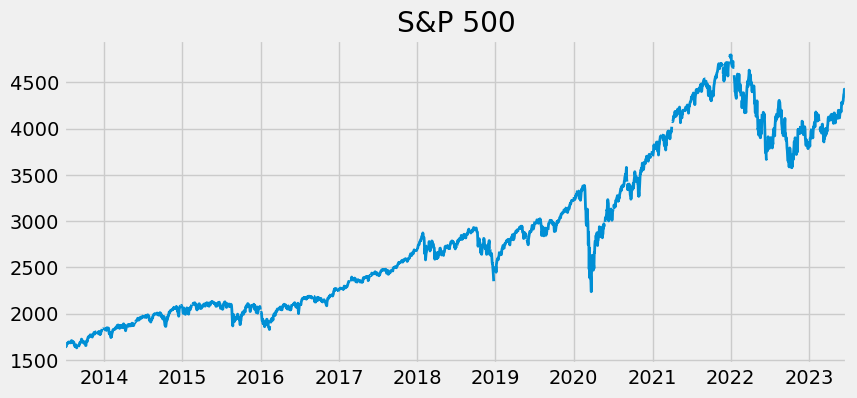

In [6]:
sp500.plot(figsize = (9, 4), title = "S&P 500", lw = 2)

## 4. Puul and Join Multiple Data Series.

In [7]:
unemp_results = fred.search("unemployment")

In [8]:
unemp_results.head(2)

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
UNRATE,UNRATE,2023-06-30,2023-06-30,Unemployment Rate,1948-01-01,2023-05-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2023-06-02 07:46:02-05:00,93,The unemployment rate represents the number of...
UNRATENSA,UNRATENSA,2023-06-30,2023-06-30,Unemployment Rate,1948-01-01,2023-05-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2023-06-02 07:45:02-05:00,52,The unemployment rate represents the number of...


<Axes: >

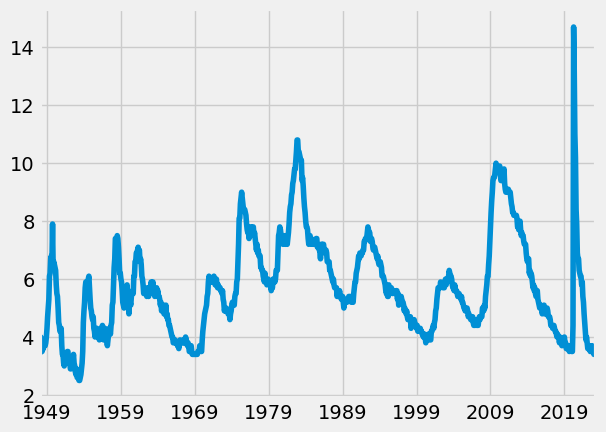

In [9]:
unrate = fred.get_series(series_id = "UNRATE")
unrate.plot()

In [111]:
unemp_df = fred.search("unemployment rate state", filter = ("frequency", "Monthly"))
unemp_df = unemp_df.query("seasonal_adjustment == 'Seasonally Adjusted' and units == 'Percent' ")

unemp_df = unemp_df.loc[unemp_df["title"].str.contains("Unemployment Rate in")]
mask = unemp_df["title"].index.str[0:3] != "LAS" 
unemp_df = unemp_df[mask]

In [35]:
columns_to_drop = ['CNEWUR', 'CWSTUR', 'VTUR', 'CNERUR', 'CSOUUR']

In [112]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name = myid)
    all_results.append(results)
    
unemp_results = pd.concat(all_results, axis = 1).drop(columns_to_drop, axis = 1)

In [118]:
unemp_results = pd.concat(all_results, axis = 1)

In [119]:
unemp_states = unemp_results.dropna(axis = 1)

In [120]:
# unemp_df = unemp_df.drop(columns_to_drop, axis = 0)

id_to_state = unemp_df["title"].str.replace("Unemployment Rate in ", '').to_dict()
id_to_state['DCUR'] = "District of Columbia"
unemp_states.columns = [id_to_state[c] for c in unemp_states.columns]

## Plot States Unemployment Rate

In [126]:
px.line(unemp_states)

## Pull April 2020 Unemployment Rate Per State

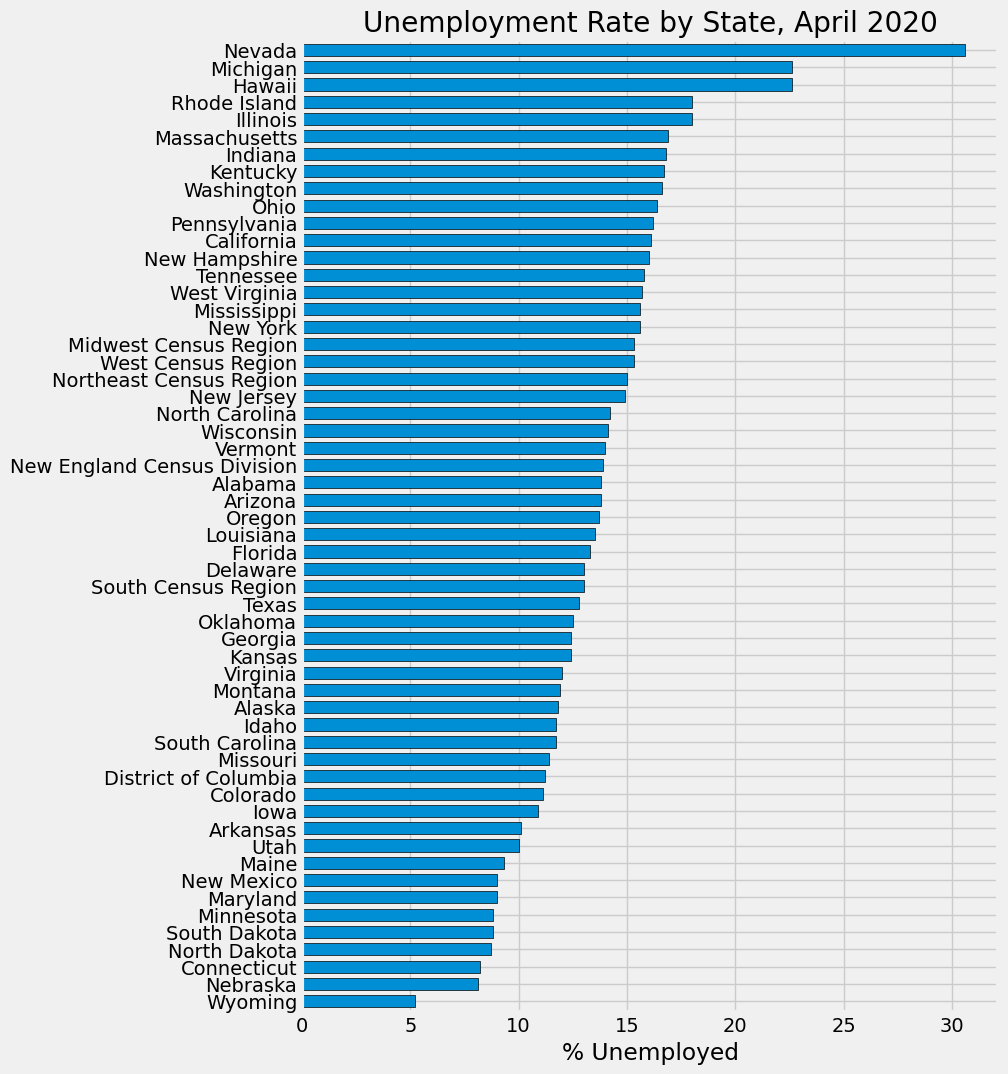

In [127]:
ax = unemp_states.loc[unemp_states.index == "2020-04-01"] \
.T.sort_values("2020-04-01") \
.plot(kind = 'barh', figsize = (8, 12), width = .7, edgecolor = "black", title = "Unemployment Rate by State, April 2020")

ax.legend().remove()
ax.set_xlabel("% Unemployed")
plt.show()

## Pull Participation Rate

In [43]:
part_df = fred.search("Labor Force", filter = ("frequency", "Monthly"))
part_df = part_df.query("seasonal_adjustment == 'Seasonally Adjusted' and units == 'Percent'")

In [44]:
part_df = part_df.loc[part_df["title"].str.contains("Labor Force Participation Rate for ")]

In [45]:
part_id_to_state = part_df["title"].str.replace("Labor Force Participation Rate for ", '').to_dict()

In [46]:
all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name = myid)
    all_results.append(results)
    
part_states = pd.concat(all_results, axis = 1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

In [128]:
part_states.head(2)

,Alabama,Florida,Wisconsin,California,Kentucky,Minnesota,Michigan,Texas,Iowa,New York,Virginia,Ohio,West Virginia,Massachusetts,Utah,Pennsylvania,Mississippi,Louisiana,Tennessee,Colorado,Arizona,Maine,Maryland,Georgia,New Mexico,Nebraska,South Carolina,North Carolina,Illinois,New Jersey,New Hampshire,Indiana,Idaho,Arkansas,Missouri,Connecticut,Washington,Oregon,North Dakota,Oklahoma,Kansas,Vermont,Nevada,District Of Columbia,Montana,Alaska,South Dakota,Wyoming,Hawaii,Delaware,Rhode Island
1976-01-01,57.0,55.8,65.6,62.6,60.5,65.6,61.6,63.8,64.4,58.0,65.9,61.7,52.5,64.8,62.8,58.4,58.8,56.8,59.6,67.2,59.5,62.1,64.3,63.7,60.8,64.9,65.3,66.5,63.0,61.5,65.9,64.0,63.0,57.9,60.5,64.2,60.9,62.9,62.6,59.3,65.1,63.6,71.3,64.4,62.7,69.0,64.6,65.3,69.9,62.7,63.8
1976-02-01,56.9,55.7,65.5,62.4,60.3,65.5,61.5,63.5,64.3,58.0,65.8,61.7,52.4,64.7,62.6,58.3,58.6,56.6,59.4,67.0,59.2,61.9,64.2,63.6,60.5,64.9,65.2,66.3,63.0,61.4,65.6,63.9,62.8,57.8,60.3,64.1,60.7,62.7,62.4,59.2,65.0,63.4,70.8,64.5,62.5,68.4,64.4,64.9,69.6,62.5,63.7


## Plot Unemployment  vs Participation

Text(0.5, 1.0, 'New York')

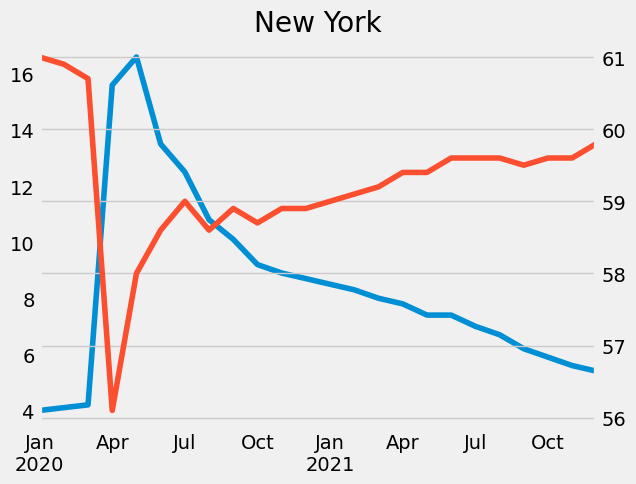

In [48]:
# Only for New York

fig, ax = plt.subplots()
ax2 = ax.twinx()
unemp_states.query("index >= 2020 and index < 2022")["New York"] \
        .plot(ax=ax, label = 'Unemployment' )

part_states.query("index >= 2020 and index < 2022")["New York"] \
        .plot(ax=ax2, label = "Participation", color = color_pal[1])
ax.grid(False)

ax.set_title("New York")